Example Code to Generate Some of the Co-12 Metrics discussed in the tutorial
**bold text**
You following the step-by-step guide here to generate replicate this for your dataset: https://beexai.readthedocs.io/en/latest/sequential.html



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install beexai

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 55.4 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=8b6915aa15d580b38af29b0d77c7e03c7309873199730210050fc86866707330
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [ ]:
import pandas as pd
import torch

from beexai.dataset.dataset import Dataset
from beexai.dataset.load_data import load_data
from beexai.training.train import Trainer
from beexai.utils.path import create_dir
from beexai.utils.time_seed import set_seed
from beexai.explanation.explaining import CaptumExplainer
from beexai.explanation.plot_attr import bar_plot, plot_swarm, plot_waterfall
from beexai.utils.sampling import stratified_sampling
from beexai.evaluate.metrics.get_results import get_all_metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

seed = 42
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DATA_NAME = "EmployeeAttrition"
MODEL_NAME = "NeuralNetwork"

In [ ]:
add_list = []
values_to_delete = []

In [ ]:
create_dir(f"/content/drive/MyDrive/Colab Notebooks/datasets/data")
CONFIG_PATH = f"/content/drive/MyDrive/Colab Notebooks/config/{DATA_NAME}.yaml"
data_test, target_col, task, dataCleaner = load_data(
    from_cleaned=False,
    config_path=CONFIG_PATH,
    keep_corr_features=True,
    values_to_delete=values_to_delete,
    add_list=add_list,
)


In [ ]:
data = Dataset(data_test, target_col)
scale_params = {
    "x_num_scaler_name": "quantile_normal",
    "x_cat_encoder_name": "ordinalencoder",
    "y_scaler_name": "labelencoder",  # change to minmax or another float scaler for regression
    "cat_not_to_onehot": ["name"],
}
X_train, X_test, y_train, y_test = data.get_train_test(
    test_size=0.2, scaler_params=scale_params
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
NUM_LABELS = data.get_classes_num(task)
NN_PARAMS = {"input_dim": X_train.shape[1], "output_dim": NUM_LABELS}
trainer = Trainer(MODEL_NAME, task, NN_PARAMS, device=device)
trainer.train(X_train, y_train, loss_file="/content/drive/MyDrive/Colab Notebooks/output/loss.png")

Loss: 0.338: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]


NNModel(
  (linear1): Linear(in_features=28, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (hidden_blocks): Sequential(
    (0): NeuralNetworkBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (linear3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
trainer.model.eval()

metrics = trainer.get_metrics(X_test, y_test)
for k, v in metrics.items():
    print(k, v)


create_dir(f"/content/drive/MyDrive/Colab Notebooks/output/models/{DATA_NAME}")
trainer.save_model(f"/content/drive/MyDrive/Colab Notebooks/output/models/{DATA_NAME}/{MODEL_NAME}.pt")

accuracy 0.8163265306122449
f1 score 0.820575995673272


In [ ]:
NUM_SAMPLES = 100
data_test, target_col, task, _ = load_data(
    from_cleaned=True, config_path=CONFIG_PATH
)
scale_params = {
    "x_num_scaler_name": "quantile_normal",
    "x_cat_encoder_name": "ordinalencoder",
    "y_scaler_name": "labelencoder",  # change to minmax or another float scaler for regression
    "cat_not_to_onehot": ["name"],
}
data = Dataset(data_test, target_col)
X_train, X_test, y_train, y_test = data.get_train_test(
    test_size=0.2, scaler_params=scale_params
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
NUM_LABELS = data.get_classes_num(task)
NN_PARAMS = {"input_dim": X_train.shape[1], "output_dim": NUM_LABELS}
trainer = Trainer(MODEL_NAME, task, NN_PARAMS, device)
trainer.load_model(f"/content/drive/MyDrive/Colab Notebooks/output/models/{DATA_NAME}/{MODEL_NAME}.pt")

/usr/local/lib/python3.10/dist-packages/beexai/training/train.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [ ]:
X_test, y_test = stratified_sampling(X_test, y_test, NUM_SAMPLES, task)


In [ ]:
METHOD = "ShapleyValueSampling"
explainer = CaptumExplainer(
    trainer.model, task=task, method=METHOD, sklearn=False, device=device
)

explainer.init_explainer()
all_preds = trainer.model.predict(X_test.values)
attributions = explainer.compute_attributions(
    X_test,
    DATA_NAME,
    MODEL_NAME,
    METHOD,
    "/content/drive/MyDrive/Colab Notebooks/output/explain/",
    all_preds,
    save=True,
    use_abs=False,
)

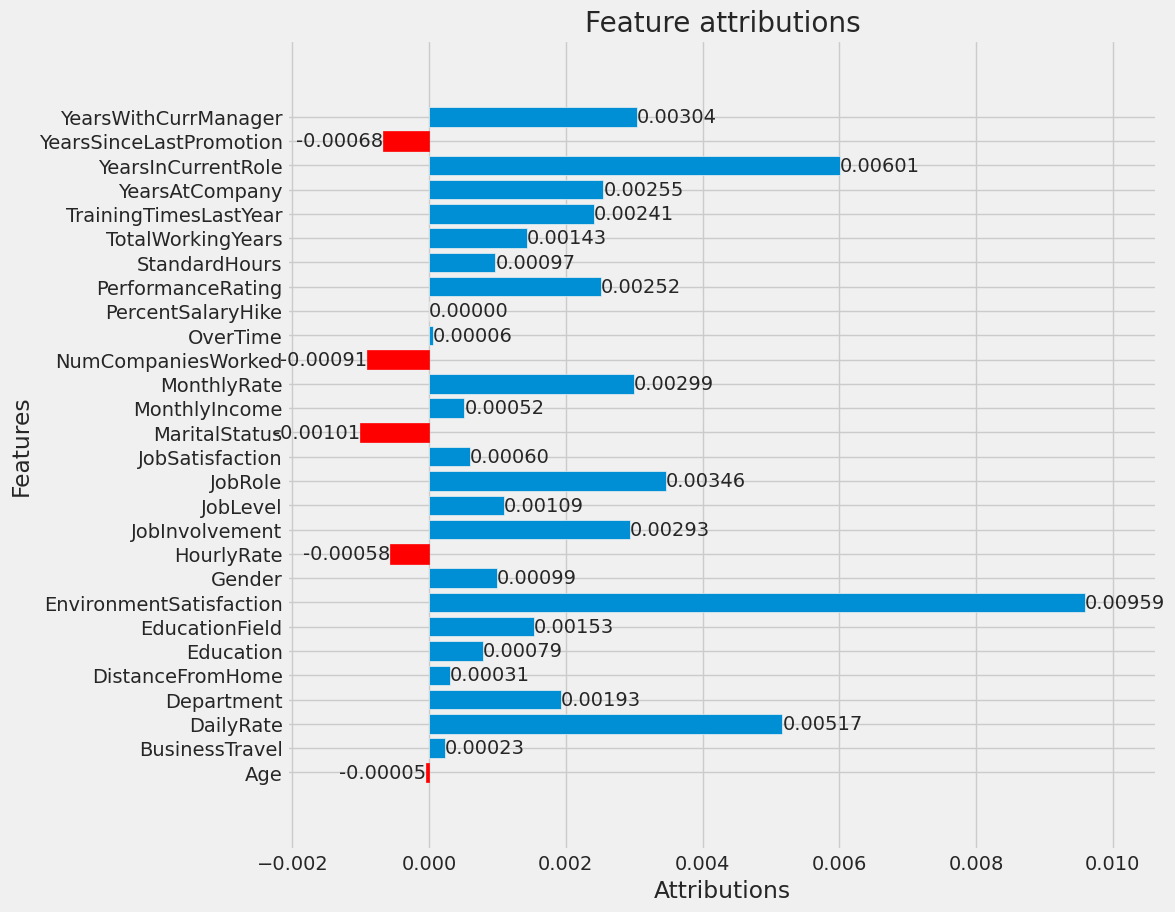

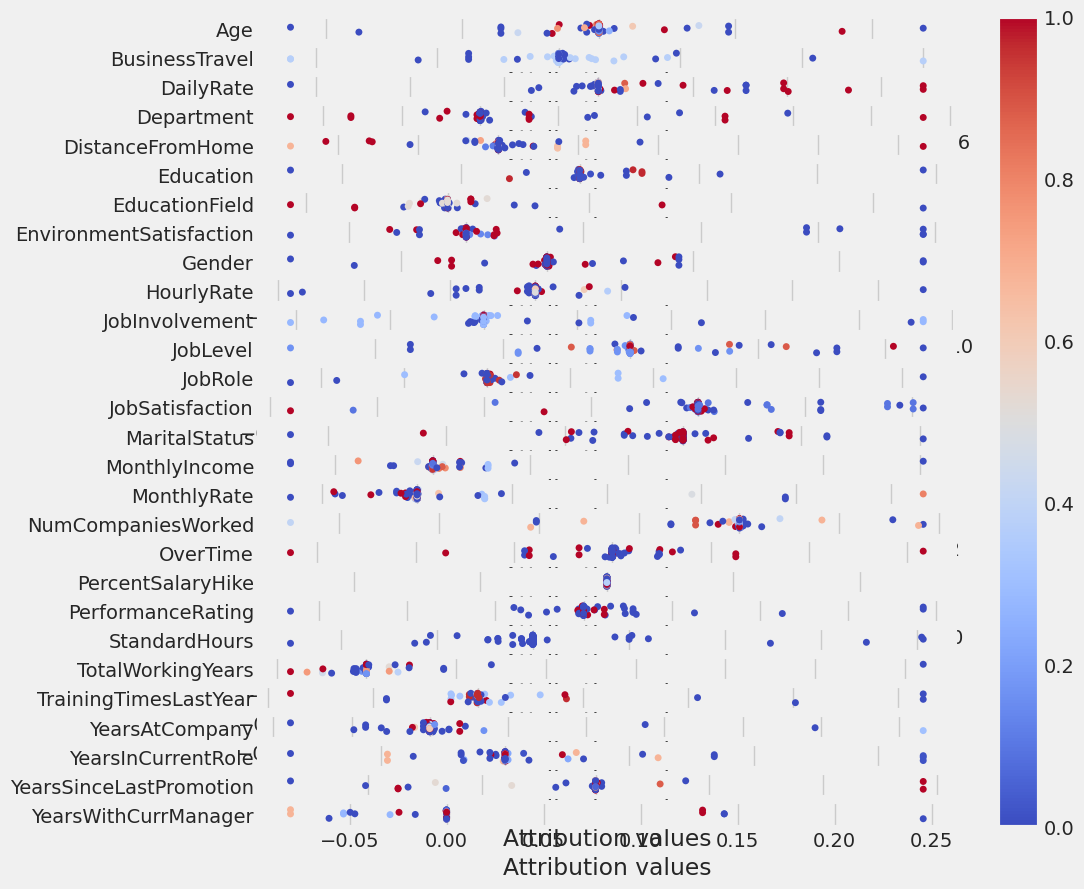

In [ ]:
features_names = list(data_test.columns)
features_names.remove(target_col)
bar_plot(attributions, feature_names=features_names, mean=True)
plot_waterfall(attributions[0], feature_names=features_names, mean=False)
plot_swarm(X_test, attributions, feature_names=features_names)

In [ ]:
DUMMY_TRAIN_SIZE = 100
X_train_sampled, y_train_sampled = stratified_sampling(
    X_train, y_train, DUMMY_TRAIN_SIZE, task
)
rand_trainer = Trainer(MODEL_NAME, task, NN_PARAMS, device)
X_perm, y_perm = X_train_sampled.values, np.random.permutation(y_train_sampled.values)
rand_trainer.train(X_perm, y_perm)
rand_trainer.model.eval()

Loss: 0.348: 100%|██████████| 1000/1000 [00:49<00:00, 20.09it/s]


NNModel(
  (linear1): Linear(in_features=28, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (hidden_blocks): Sequential(
    (0): NeuralNetworkBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (linear3): Linear(in_features=32, out_features=2, bias=True)
)

compute_faith_corr took 0.18846821784973145 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_inf took 1.362114429473877 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_sens took 2.6107125282287598 seconds


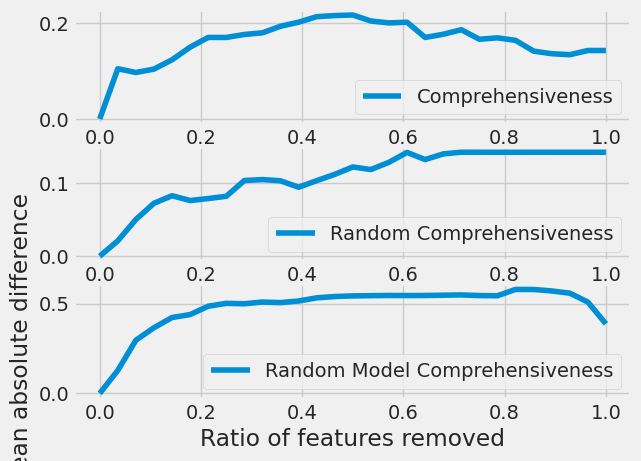

compute_comp took 1.772939920425415 seconds


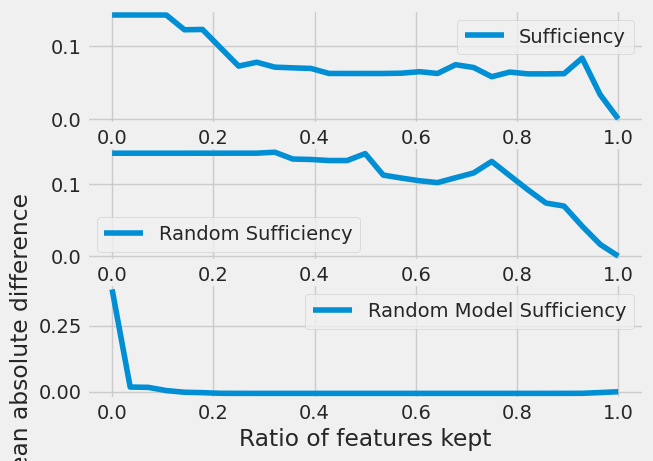

compute_suff took 2.450068235397339 seconds
compute_mono took 0.42873096466064453 seconds


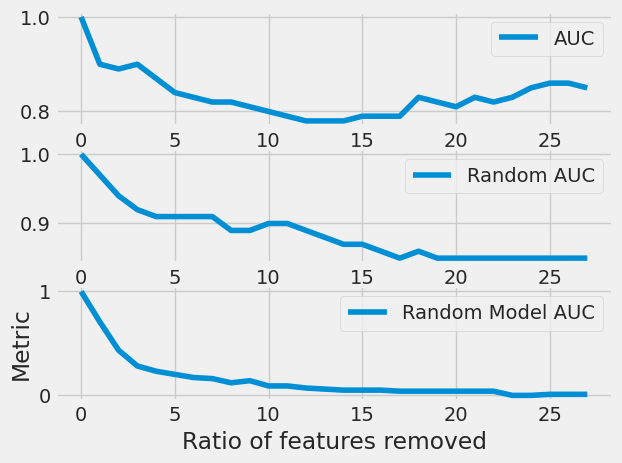

compute_auc took 2.6162116527557373 seconds
compute_complex took 0.038137197494506836 seconds
compute_spar took 0.014012336730957031 seconds
-------------------
  FaithCorr                        Infidelity                         \
   Original    Random Random Model   Original    Random Random Model   
0  0.449277 -0.038021     0.152281   0.780688  3.596154     0.476842   

  Sensitivity                        Comprehensiveness                         \
     Original    Random Random Model          Original    Random Random Model   
0    0.267804  1.448713     0.246247          0.176218  0.103912     0.498855   

  Sufficiency                        Monotonicity                         \
     Original    Random Random Model     Original    Random Random Model   
0    0.077883  0.142834    -0.006235      0.62963  0.703704     0.703704   

     AUC_TP                       Complexity                         \
   Original   Random Random Model   Original    Random Random Model   
0  0.79

FaithCorr                        Infidelity                         \
   Original    Random Random Model   Original    Random Random Model   
0  0.449277 -0.038021     0.152281   0.780688  3.596154     0.476842   

  Sensitivity                        Comprehensiveness                         \
     Original    Random Random Model          Original    Random Random Model   
0    0.267804  1.448713     0.246247          0.176218  0.103912     0.498855   

  Sufficiency                        Monotonicity                         \
     Original    Random Random Model     Original    Random Random Model   
0    0.077883  0.142834    -0.006235      0.62963  0.703704     0.703704   

     AUC_TP                       Complexity                         \
   Original   Random Random Model   Original    Random Random Model   
0  0.798882  0.85083     0.131674   0.064749  0.110488     0.094057   

  Sparseness                         
    Original    Random Random Model  
0   0.787725  0.372845     0.614283

In [ ]:
METHOD = "ShapleyValueSampling"
exp = CaptumExplainer(
    trainer.model, task=task, method=METHOD, sklearn=False, device=device
)
exp.init_explainer()
attributions = exp.compute_attributions(
    X_test, DATA_NAME, MODEL_NAME, METHOD, "/content/drive/MyDrive/Colab Notebooks/output/explain/", use_abs=False
)

rand_exp = CaptumExplainer(
    rand_trainer.model, task=task, method=METHOD, sklearn=False, device=device
)
rand_exp.init_explainer()
rand_attributions = rand_exp.compute_attributions(
    X_test, DATA_NAME, MODEL_NAME, METHOD, "../output/explain/", use_abs=False
)

all_preds = trainer.model.predict(X_test.values)

get_all_metrics(
    X_test,
    all_preds,
    trainer.model,
    exp,
    rand_trainer.model,
    rand_exp,
    print_plot=True,
    auc_metric="accuracy",
    device=device,
    use_random=True,
    use_ref=True,
    attributions=attributions,
    attributions_ref=rand_attributions,
)